In [1]:
# 导入依赖
import numpy as np
import matplotlib.pyplot as plt
from mzm.model import simulate_mzm, simulation_summary
from mzm.plot import plot_optical_spectrum_osa, plot_electrical_spectrum, plot_bias_scan

%config InlineBackend.figure_format = 'retina'

# 设置中文字体与负号显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 1. 运行一次仿真（参数等价于 MATLAB 脚本）
sim = simulate_mzm(
    SymbolRate=10e9,
    Fs=100e9,
    T_total=10e-6,
    Vpi_RF=5.0,
    Vpi_DC=5.0,
    ER_dB=30.0,
    IL_dB=6.0,
    Responsivity=0.786,
    R_load=50.0,
    Pin_dBm=10.0,
    Temp_K=290.0,
    RIN_dB_Hz=-145.0,
    f_rf=1e9,
    V_rf_amp=0.2,
)

summary = simulation_summary(sim)
for k, v in summary.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")

Pin_dBm: 10.0000
P_pd_avg_dBm: 0.7236
RBW_Hz: 99999.9000
P_noise_floor_dBm: -108.0919
P_density_dBmHz: -158.0919
val_1G_dBm: -34.7167
val_2G_dBm: -105.1339


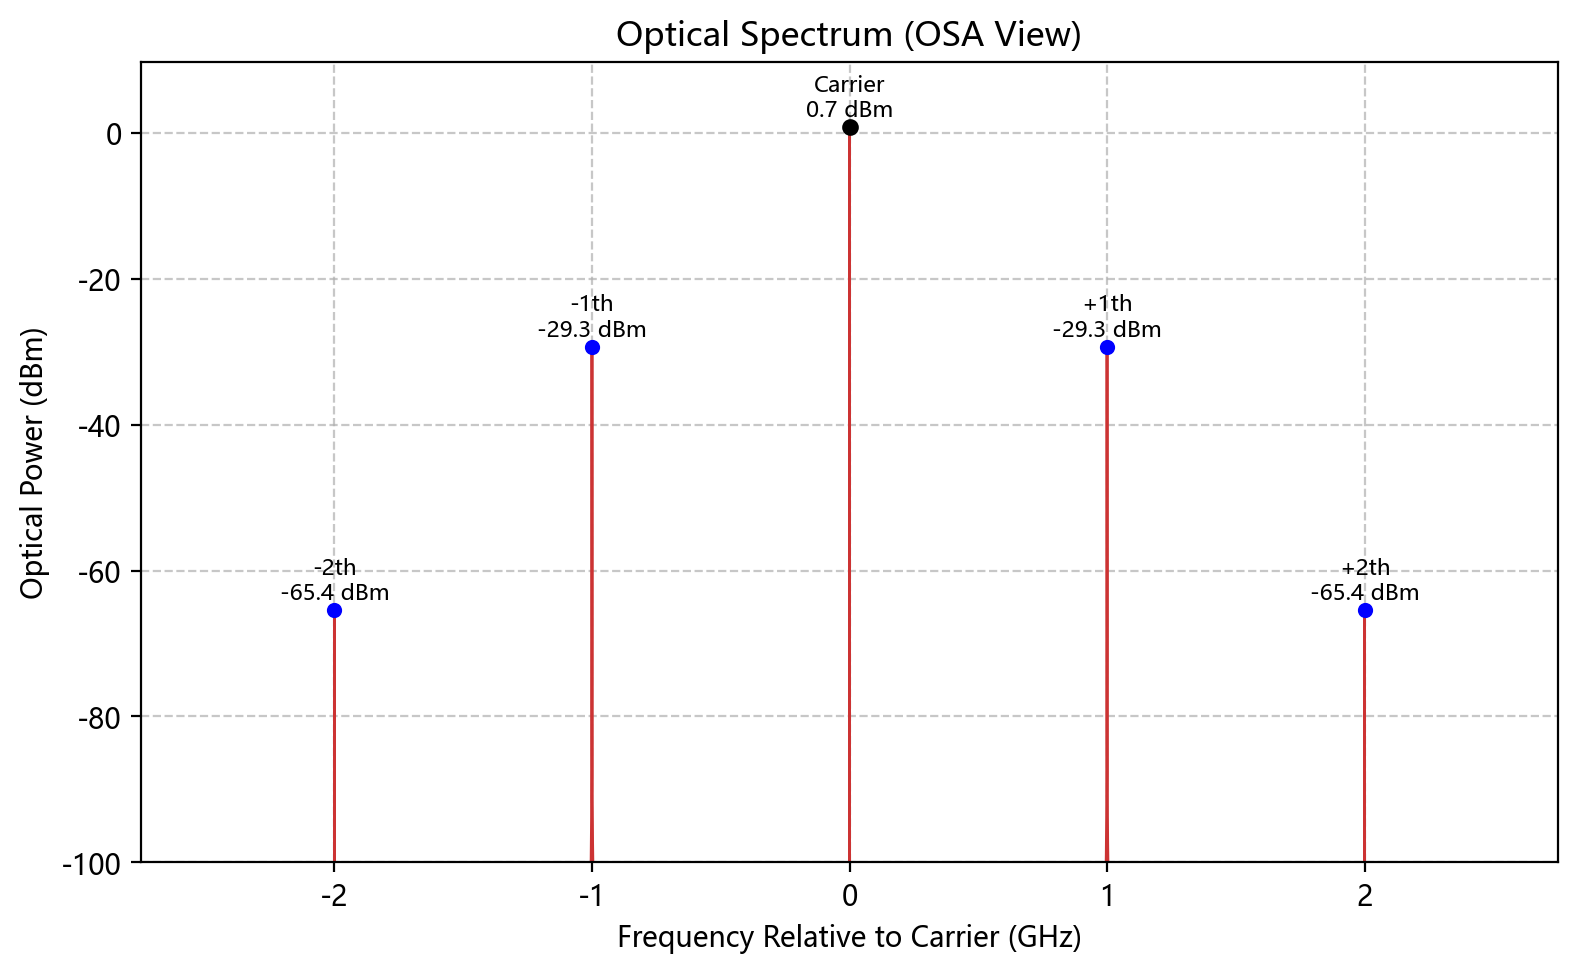

In [3]:
# 2. 输出光谱（OSA 视图，自动标注载波与 ±1/±2 阶）
plot_optical_spectrum_osa(sim, f_rf_hz=1e9, max_order=2)
plt.show()

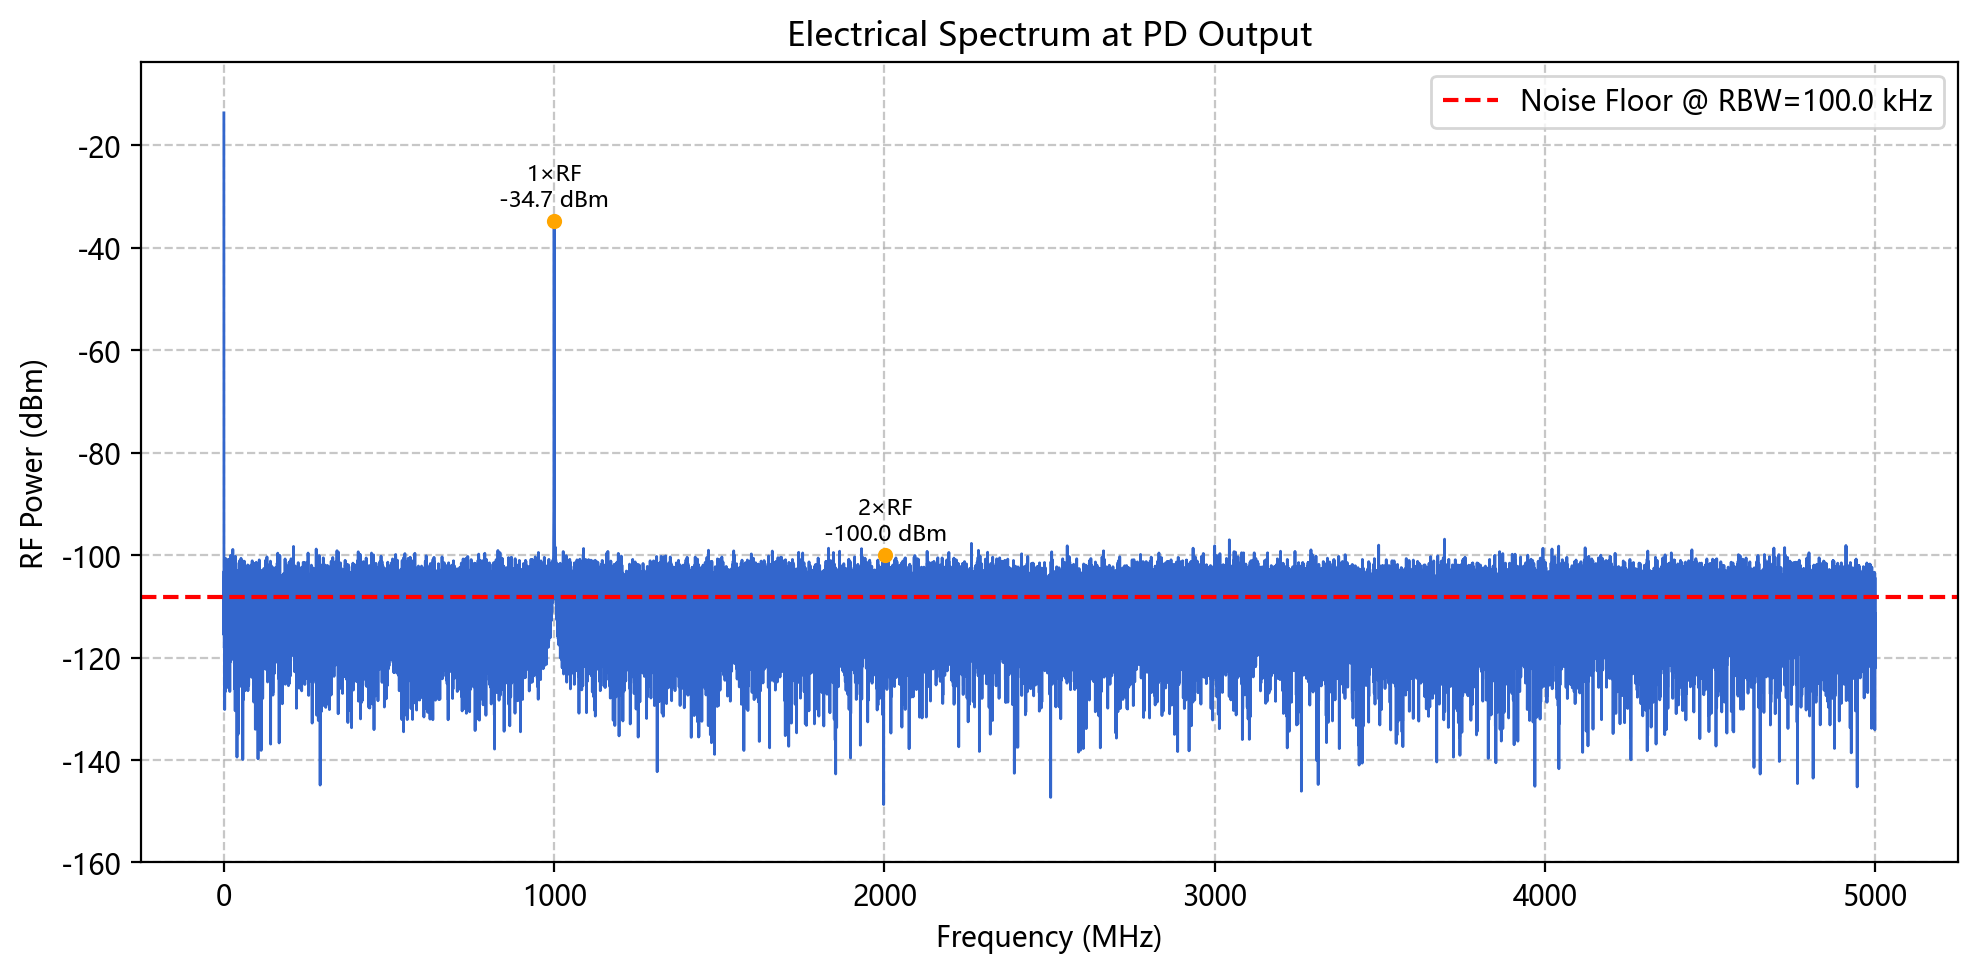

In [4]:
# 3. 带噪底的电谱（自动标注 1×/2×RF）
plot_electrical_spectrum(sim, f_rf_hz=1e9, harmonic_orders=(1, 2))
plt.show()

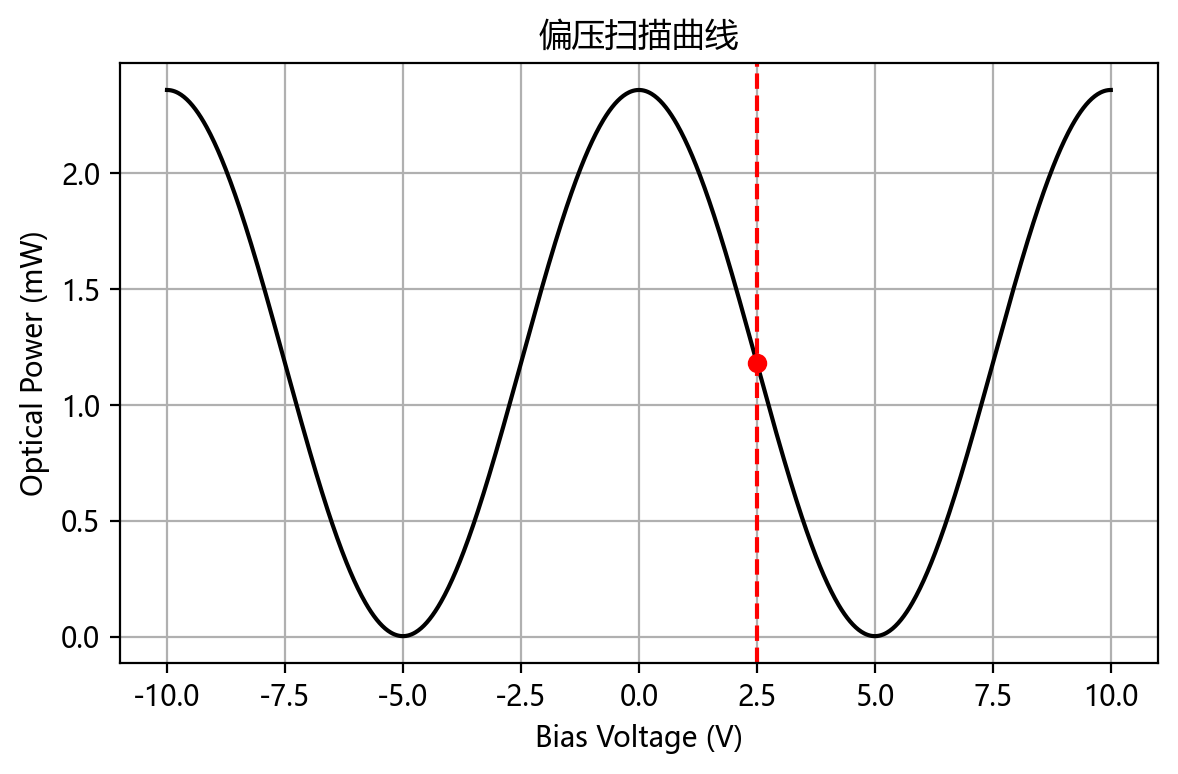

In [5]:
# 4. 偏压扫描曲线
plot_bias_scan(sim)
plt.show()